In [1]:
import cv2
import kagglehub
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt

/Users/zach/Documents/aai521-group1/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zach/Documents/aai521-group1/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gather the dataset

In [5]:
# Download latest version
path = kagglehub.dataset_download("semiemptyglass/cyclist-dataset")
dataset_path = os.path.join(path, "data_tsinghua")
images_path = os.path.join(dataset_path, "images")
labels_path = os.path.join(dataset_path, "labels")

## Function to draw bounding boxes

In [3]:
def draw_bounding_boxes(image_path, label_path):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    height, width, _ = img.shape
    
    # Read YOLO labels
    with open(label_path, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        label = line.strip().split()
        class_id, center_x, center_y, box_width, box_height = map(float, label)
        
        # Convert YOLO format to OpenCV rectangle format
        x1 = int((center_x - box_width / 2) * width)
        y1 = int((center_y - box_height / 2) * height)
        x2 = int((center_x + box_width / 2) * width)
        y2 = int((center_y + box_height / 2) * height)
        
        # Draw rectangle on the image
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Convert BGR image to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image with bounding boxes in Jupyter
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis
    plt.show()

# Example usage:
# image_path = f"{path}/data_tsinghua/images/000000.jpg"  
# label_path = f"{path}/data_tsinghua/labels/000000.txt"  
# draw_bounding_boxes(image_path, label_path)

## Code to create the model

In [6]:
# Creatint a config to train the model
data_yaml = """
train: {images_path}
val: {images_path}

nc: 1
names: ['cyclist']
""".format(images_path=images_path)

yaml_path = os.path.join(path, "cyclist_dataset.yaml")
with open(yaml_path, "w") as f:
    f.write(data_yaml)

# Train YOLOv8 model
model = YOLO("yolov8n.pt") 

model.train(
    data=yaml_path,      
    epochs=10,           
    imgsz=320,           
    batch=8,             
    workers=8,           
    save=True,           
)

Ultralytics 8.3.39 🚀 Python-3.9.6 torch-2.5.1 CPU (Apple M3 Pro)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/Users/zach/.cache/kagglehub/datasets/semiemptyglass/cyclist-dataset/versions/1/cyclist_dataset.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

KeyboardInterrupt: 

## Function to create labels from an image

In [7]:
# Using best weights
best_weights_path = os.path.join("runs", "detect", "train4", "weights", "best.pt")
model = YOLO(best_weights_path)

# Generate Labels for image
def create_labels(image_path, model, output_label_path):
    results = model(image_path)
    img = cv2.imread(image_path)
    height, width, _ = img.shape

    with open(output_label_path, 'w') as label_file:
        for detection in results[0].boxes:
            class_id = int(detection.cls)
            x1, y1, x2, y2 = detection.xyxy.numpy().flatten()
            box_width = (x2 - x1) / width
            box_height = (y2 - y1) / height
            center_x = (x1 + x2) / (2 * width)
            center_y = (y1 + y2) / (2 * height)
            label_file.write(f"{class_id} {center_x} {center_y} {box_width} {box_height}\n")


image 1/1 /Users/zach/.cache/kagglehub/datasets/semiemptyglass/cyclist-dataset/versions/1/data_tsinghua/images/000002.jpg: 160x320 1 cyclist, 12.3ms
Speed: 0.5ms preprocess, 12.3ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 320)
Results saved to /Users/zach/Documents/aai521-group1/runs/detect/predict5

image 1/1 /Users/zach/.cache/kagglehub/datasets/semiemptyglass/cyclist-dataset/versions/1/data_tsinghua/images/000002.jpg: 160x320 1 cyclist, 8.4ms
Speed: 0.4ms preprocess, 8.4ms inference, 0.6ms postprocess per image at shape (1, 3, 160, 320)
Labels saved to testing/000002.txt


## Usage


image 1/1 /Users/zach/Documents/aai521-group1/testing/000002.jpg: 160x320 1 cyclist, 14.1ms
Speed: 0.7ms preprocess, 14.1ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 320)
Results saved to /Users/zach/Documents/aai521-group1/runs/detect/predict5

image 1/1 /Users/zach/Documents/aai521-group1/testing/000002.jpg: 160x320 1 cyclist, 12.6ms
Speed: 0.5ms preprocess, 12.6ms inference, 0.2ms postprocess per image at shape (1, 3, 160, 320)


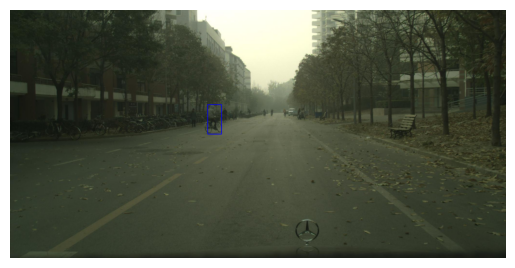

In [18]:
# Testing on an image
image_file = '000002'
test_image_path = os.path.join("testing", f"{image_file}.jpg")
results = model(test_image_path, save=True) 

output_label_path = os.path.join("testing", f"{image_file}.txt")
create_labels(test_image_path, model, output_label_path)
draw_bounding_boxes(test_image_path, output_label_path)